# Discrete HMM and optical character recognition

Recall that hidden Markov model (HMM) can be viewed as an add-on to clustering that enforces continuity between adjacent observations.
Optical character recognition is often viewed as a supervised learning task. However, it can be thought as an unsupervised learning task:

* Group together all subimages representing the same character.
* Learn the transformations between clusters that represent characters.

As manual data labelling is costly, such an unsupervised approach could be used as the first step for gathering labelled data. 
The approach also allows us to illustrate the connection between clustering and hidden Markov models.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from matplotlib import pyplot as plt
import sklearn

from pandas import Series
from pandas import DataFrame
from typing import Tuple

from tqdm import tnrange#, tqdm_notebook
from plotnine import *

from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

# Local imports
from common import *
from convenience import *

from matplotlib.patches import Rectangle, Path, PathPatch
from PIL import Image

## I. Data import and initial adjustement

We are going to use one page from a CIA document from 1967 referring to Area 51 for no particular reason.
As the image is slightly tilted, we do a manual adjustment. 

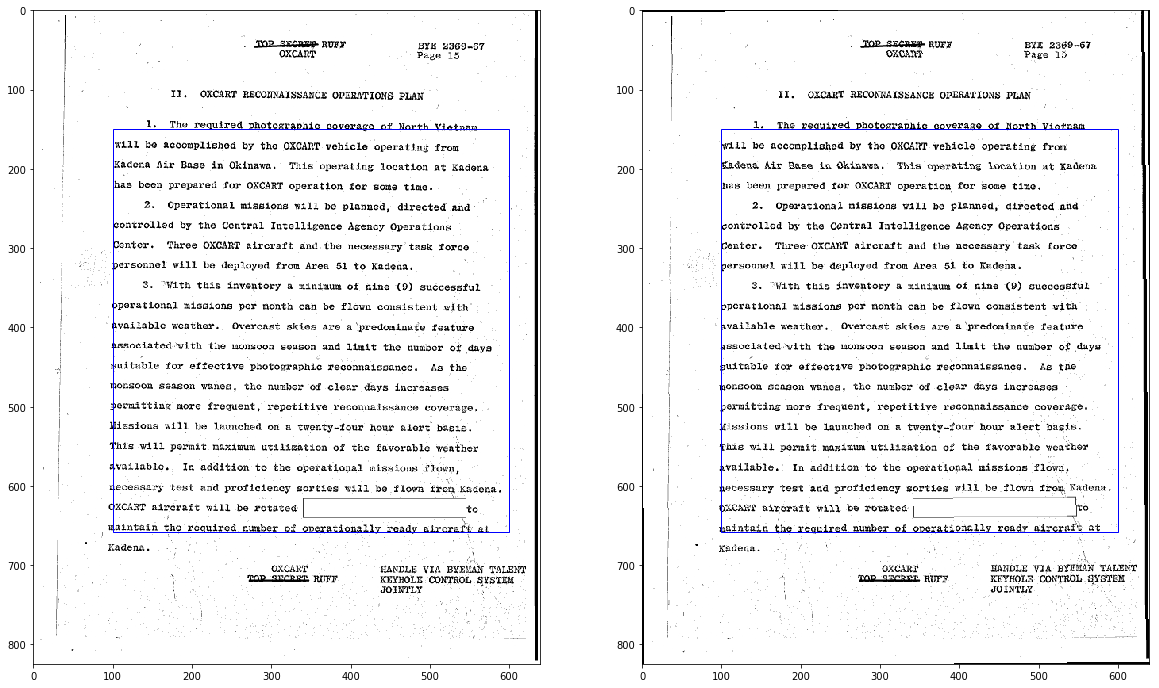

In [2]:
image = plt.imread('data/ocr-data/oxcart-operation-plan.png')

fig=plt.figure(figsize=(20,20))
fig.add_subplot(1, 2, 1)
plt.imshow(image)
plt.gca().add_patch(Rectangle((100, 150), 500, 508,linewidth=1,edgecolor='blue',facecolor='none'))
fig.add_subplot(1, 2, 2)
img=Image.open('data/ocr-data/oxcart-operation-plan.png')
plt.imshow(img.rotate(0.4), cmap ='gray')
plt.gca().add_patch(Rectangle((100, 150), 500, 508,linewidth=1,edgecolor='blue',facecolor='none'))
img.rotate(0.4).save('data/oxcart-operation-plan-rotated.png')

### Grayscale conversion and intensity histogram

In [3]:
def convert_to_grayscale(image: np.array)-> np.array:
    """Converts RGB image to grayscale image preserving perceived luminocity based on Y_601 formula""" 
    return 0.2989 * image[:,:,0] + 0.5870 * image[:,:,1] + 0.1140 * image[:,:,2]

In [4]:
bw_image = convert_to_grayscale(np.array(img.rotate(0.4)))
unique_elements, counts_elements = np.unique(bw_image, return_counts=True)
display(DataFrame(unique_elements, columns=['intensity']).assign(count=counts_elements))

,intensity,count
0,0.0000,16692
1,53.9946,11082
2,126.9873,11447
3,199.9800,16560
4,253.9746,6592
5,254.9745,465627


## II. Semi-manual segmentation into words and characters

Now we will segment the image into lines of text, words and characters. For simplicity, we will detect the lines of text manually, although it could also be automated similarly to word and character segmentation which will be implemented shortly after.

### Manual detection of text lines

,i0,i1,j0,j1
0,139,149,140,560
1,165,175,100,535
2,190,200,99,574
3,215,225,99,494
4,240,250,138,548


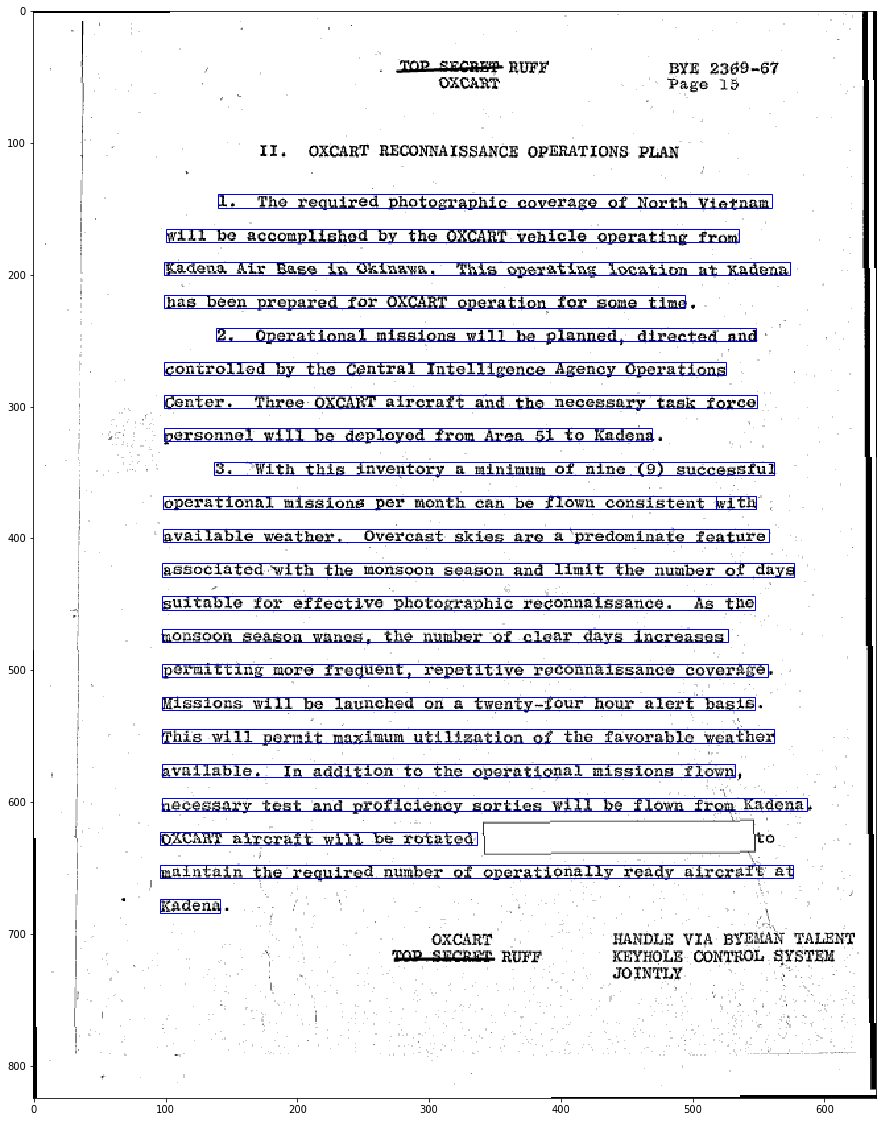

In [5]:
fig=plt.figure(figsize=(20,20))
plt.imshow(bw_image, cmap ='gray')
ax = plt.gca()
X = [140, 100,  99,  99, 138,  99,  99,  99, 137,  98,  98,  98,  97,  97,  97,  97,  97,  97,  97,  97,  96,  96,  96]
Y = [139, 165, 190, 215, 240, 266, 291, 316, 342, 368, 368, 393, 419, 444, 469, 495, 520, 545, 571, 597, 623, 648, 674]
L = [420, 435, 475, 395, 410, 426, 450, 370, 425, 420, 450, 460, 480, 450, 430, 460, 450, 465, 435, 490, 240, 480, 45]

# Visualisation
for i, x in enumerate(X):
    ax.add_patch(Rectangle((x, Y[i]), L[i], 10, linewidth=1, edgecolor='blue', facecolor='none'))

# Resulting coordinates of text lines.
# Note that matrix coordinates are switched
line_boxes = np.array([Y, Y, X, X])
line_boxes[1, :] += 10
line_boxes[3, :] += L
line_boxes = DataFrame(line_boxes.T, columns = ['i0', 'i1', 'j0', 'j1'])
display(head(line_boxes))

### Automatic detection of word and character boundaries

To detect words and characters, we use the same strategy:
* First, we detect almost white vertical regions. 
* Next, we apply restrictions to gaps and characters to adjust the initial guesses.

In [6]:
def detect_word_boundaries(line: np.array, white_treshold:float=150, quantile:float=0.9, min_gap:int=5) -> np.array:
    """Detects words by throwing out long enough white gaps
    
       The gap is defined through three parameters:
       – white_threshold specifies what is the minimal pixel value to be white
       – quantile specifies the fraction of pixels that must be white in the gap
       – min_gap specifies what is the length of the minimal gap between words 
    """

    n = line.shape[1]
    whites = np.mean(line > white_treshold, axis=0) >= quantile
    
    # Find the start of the first word
    S = [0]
    while S[0] < n and whites[S[0]]:
        S[0] += 1
    
    k = 0
    E = [S[0]]
    while E[k] < n:
    
        # Go to the first white stripe
        while E[k] < n and not whites[E[k]]:
            E[k] += 1
        
        # Look for the first non-white stripe
        j = E[k]
        while j < n and whites[j]:
            j += 1
        
        # Start a new word if the white gap is large enough
        if j - E[k] > min_gap:
            S.append(j)
            E.append(j)
            k += 1
        else:
            E[k] = j
        
    return np.array([S, E]).T   

In [7]:
def detect_words(bw_image: np.array, line_boxes: DataFrame):
    result = np.full([0, 4], np.nan)
    i = 0
    for row in line_boxes.itertuples():
        line = bw_image[row.i0:row.i1, row.j0:row.j1]
        words = detect_word_boundaries(line) + row.j0
        words = np.insert(words, 0, row.i0, axis=1) 
        words = np.insert(words, 1, row.i1, axis=1) 
        result = np.concatenate((result, words))
    return DataFrame(result, columns = ['i0', 'i1', 'j0', 'j1'], dtype=int)   

,word,i0,i1,j0,j1
0,0,139,149,141,153
1,1,139,149,170,192
2,2,139,149,201,261
3,3,139,149,271,359
4,4,139,149,368,428


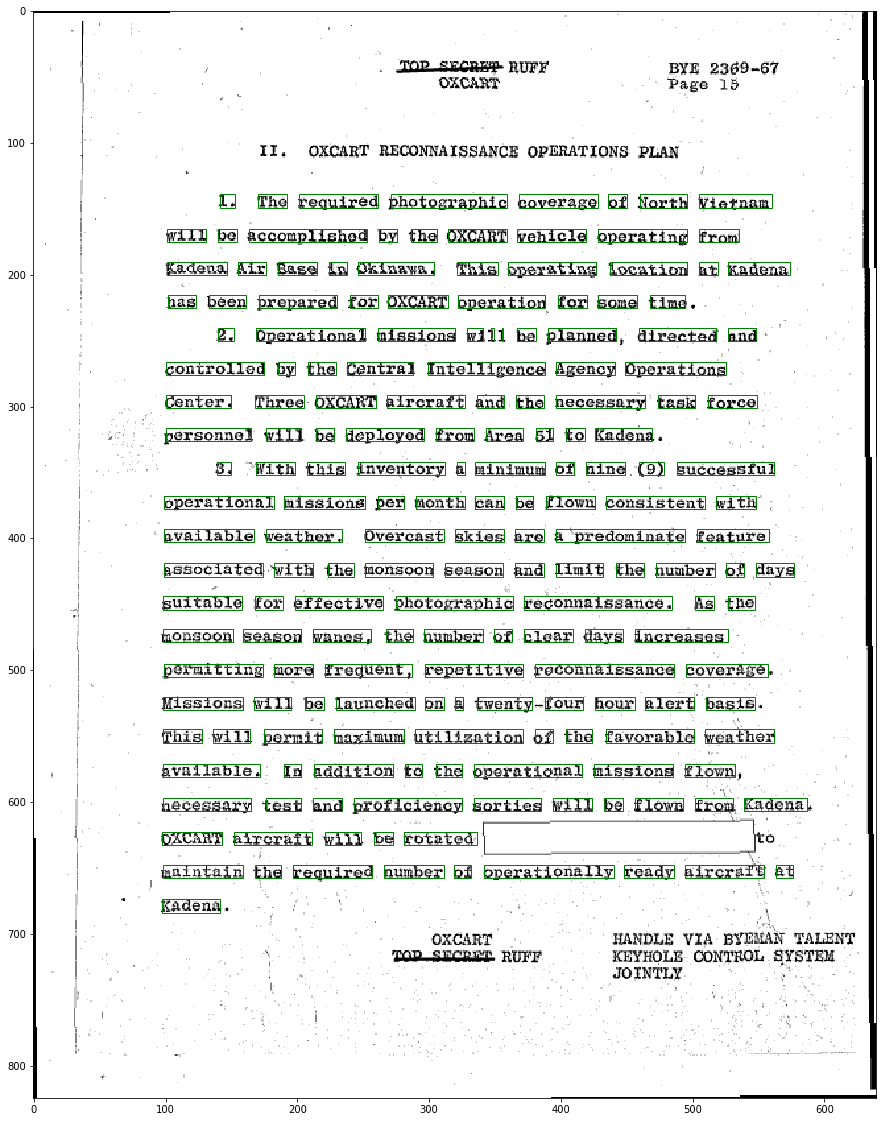

In [8]:
word_boxes = (detect_words(bw_image, line_boxes)
              .assign(word = lambda df: df.index.values)
              [['word', 'i0', 'i1', 'j0', 'j1']])
display(head(word_boxes))

# Visual validation
fig=plt.figure(figsize=(20,20))
plt.imshow(bw_image, cmap ='gray')
ax = plt.gca()
for row in word_boxes.itertuples():
    ax.add_patch(Rectangle((row.j0, row.i0), row.j1 - row.j0, row.i1-row.i0,  
                           linewidth=1, facecolor='None', edgecolor='green')) 

In [9]:
def detect_letter_boundaries(word:np.array, min_len:int = 6, max_len:int = 8):
    
    n = word.shape[1]
    means = np.mean(word, axis=0)
    whites = np.mean(word > 150, axis=0) >= 0.8

    j = 0
    k = 0
    S = [0]
    while S[k] + min_len < n:
        
        j = S[k] + min_len
        jmax = min(n, S[k] + max_len + 1)
        
        # Look for the first white stripe
        while j < jmax and not whites[j]:
            j += 1

        if j == n:
            break
        
        S.append(j)
        k += 1
        j += 1
        
        # Look for the better alternative
        while j < jmax and whites[j]:
            if means[j] > means[S[k]]:
                S[k] = j
            j += 1
            
    return np.array([S, S[1:] + [n]]).T

In [10]:
def detect_words(bw_image: np.array, word_boxes: DataFrame):
    result = np.full([0, 6], np.nan)
    for row in word_boxes.itertuples():
        word = bw_image[row.i0:row.i1, row.j0:row.j1]
        letters = detect_letter_boundaries(word) + row.j0
        letters = np.insert(letters, 0, row.i0, axis=1) 
        letters = np.insert(letters, 1, row.i1, axis=1)
        letters = np.insert(letters, 0, row.word, axis=1)
        letters = np.insert(letters, 1, range(len(letters)), axis=1)
        result = np.concatenate((result, letters))
    return DataFrame(result, columns = ['word', 'char', 'i0', 'i1', 'j0', 'j1'], dtype=int)   

,word,char,i0,i1,j0,j1
0,0,0,139,149,141,147
1,0,1,139,149,147,153
2,1,0,139,149,170,178
3,1,1,139,149,178,185
4,1,2,139,149,185,192
5,2,0,139,149,201,208
6,2,1,139,149,208,216
7,2,2,139,149,216,223
8,2,3,139,149,223,231
9,2,4,139,149,231,238


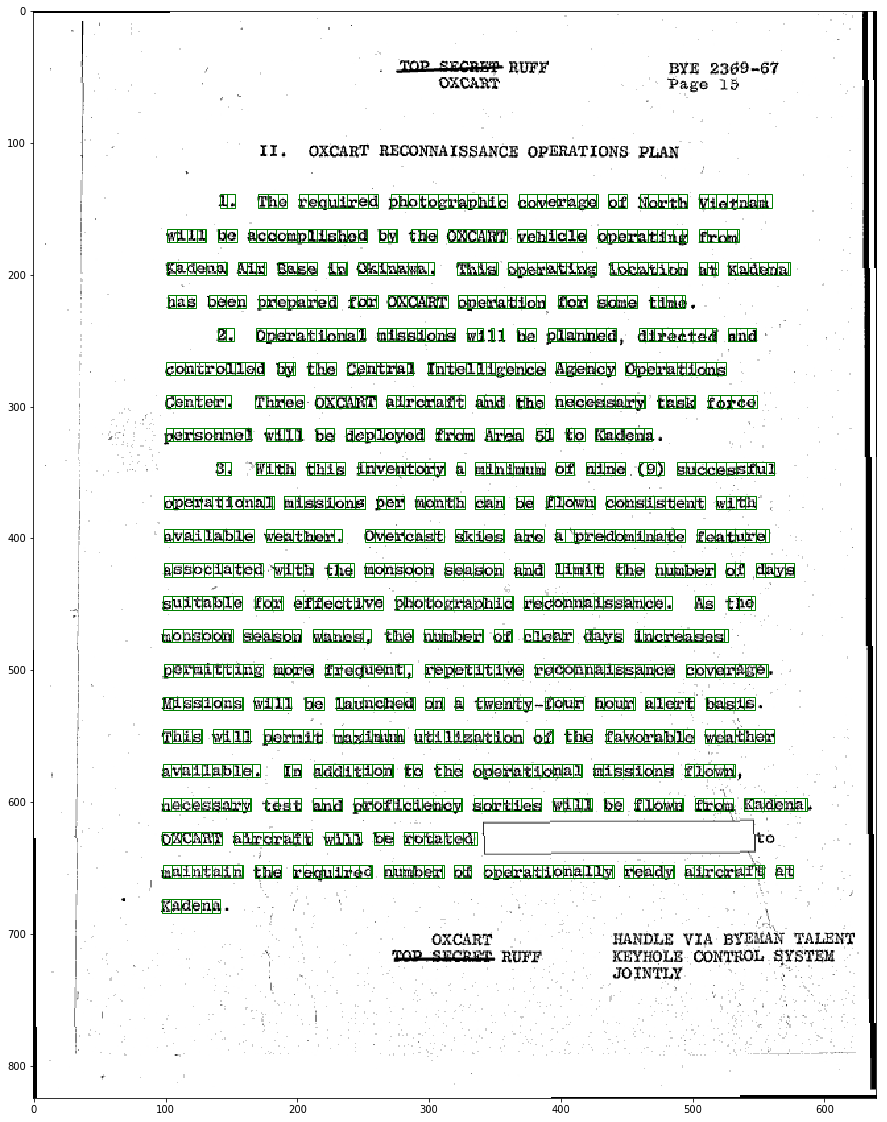

In [11]:
letter_boxes = detect_words(bw_image, word_boxes)

display(head(letter_boxes,10))

# Visual validation
fig=plt.figure(figsize=(20,20))
plt.imshow(bw_image, cmap ='gray')
ax = plt.gca()
for row in letter_boxes.itertuples():
    ax.add_patch(Rectangle((row.j0, row.i0), row.j1 - row.j0, row.i1-row.i0,  linewidth=1, facecolor='None', edgecolor='green')) 

## III. Construction of input sequences

As we have some failed segmentations and all segments are not equal, we need to do some rudimentary cleaning before converting images into texture vectors.

In [13]:
head(letter_boxes)

,word,char,i0,i1,j0,j1
0,0,0,139,149,141,147
1,0,1,139,149,147,153
2,1,0,139,149,170,178
3,1,1,139,149,178,185
4,1,2,139,149,185,192


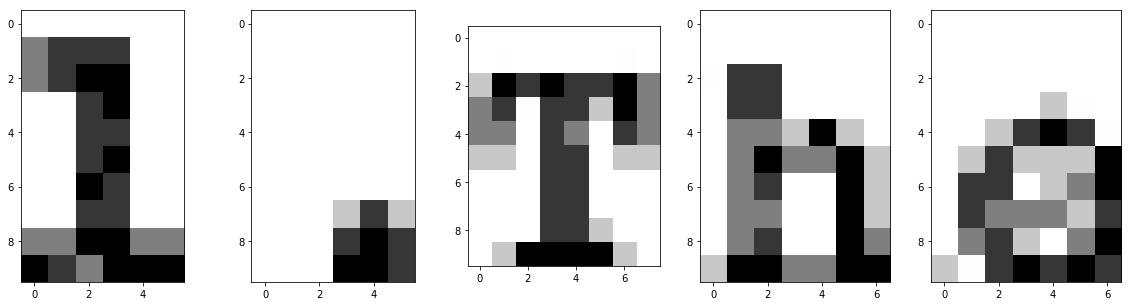

In [17]:
fig=plt.figure(figsize=(20,5))
for i in range(5):
    fig.add_subplot(1, 5, i + 1)
    box = bw_image[letter_boxes.loc[i, 'i0']:letter_boxes.loc[i, 'i1'],
               letter_boxes.loc[i, 'j0']:letter_boxes.loc[i, 'j1']]

    plt.imshow(box, cmap='gray')

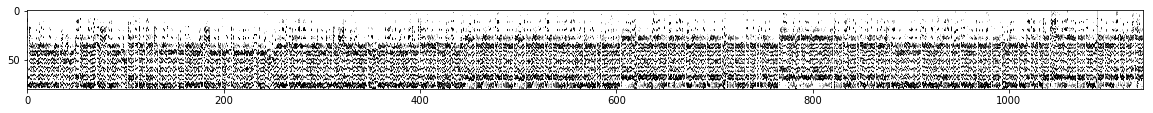

In [18]:
textures = np.empty([len(letter_boxes),80])
for row in letter_boxes.itertuples():
    subimage = bw_image[row.i0:row.i1, row.j0: row.j1]
    if subimage.shape[0] * subimage.shape[1] >0:
        letter = np.full([10, 9], subimage.max())
        letter[:row.i1-row.i0, :row.j1-row.j0] = subimage
        textures[row.Index, :] = letter[:, :8].reshape([80])
    else:
        textures[row.Index, :] = 255

fig=plt.figure(figsize=(20,5))
plt.imshow(textures.T, cmap='gray')

## IV. Probabilistic model for the image and initial clustering

We use the simplest model possible – Bernoulli model. For that, we binarise inputs by thresholding the texture vector. We assume that each input belongs to one of the pre-specified number of clusters and all 80 vector elements of each input are generated by independent coin tosses using a cluster-specific bias vector $\boldsymbol{p}$. 

To get initial parameter values, we use hierarchical clustering with 35 clusters to get initial cluster labels and then compute corresponding cluster parameters with Laplace smoothing.

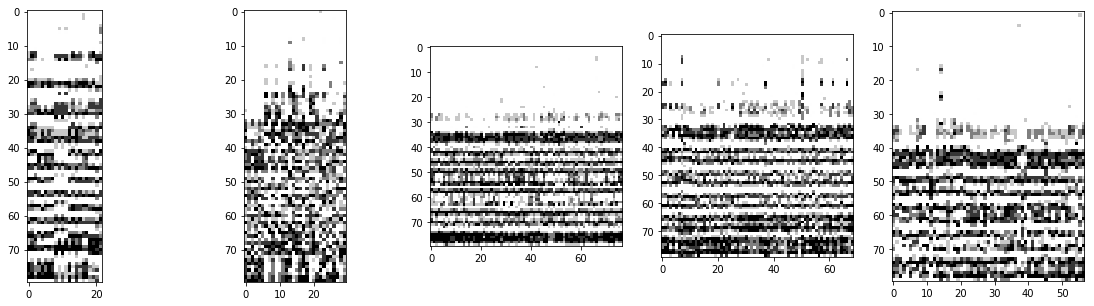

In [19]:
labels = AgglomerativeClustering(n_clusters=35, linkage='ward').fit(textures).labels_

fig=plt.figure(figsize=(20,5))
for i in range(5):
    fig.add_subplot(1, 5, i + 1)
    plt.imshow(textures[labels==i,].T, cmap='gray')

In [20]:
columns = ['x{:02d}'.format(i) for i in range(textures.shape[1])]
df = (DataFrame(textures > 150, columns = columns, dtype=int)
      .assign(word = letter_boxes['word'])
      .assign(char = letter_boxes['char'])
      .assign(label = labels)
      [['word', 'char', 'label'] + columns])
head(df)

,word,char,label,x00,x01,x02,x03,x04,x05,x06,...,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79
0,0,0,31,1,1,1,1,1,1,1,...,1,1,0,0,0,0,0,0,1,1
1,0,1,8,1,1,1,1,1,1,1,...,1,1,1,1,1,0,0,0,1,1
2,1,0,7,1,1,1,1,1,1,1,...,1,1,1,1,0,0,0,0,1,1
3,1,1,3,1,1,1,1,1,1,1,...,0,1,1,0,0,0,0,0,0,1
4,1,2,34,1,1,1,1,1,1,1,...,0,1,1,1,0,0,0,0,0,1


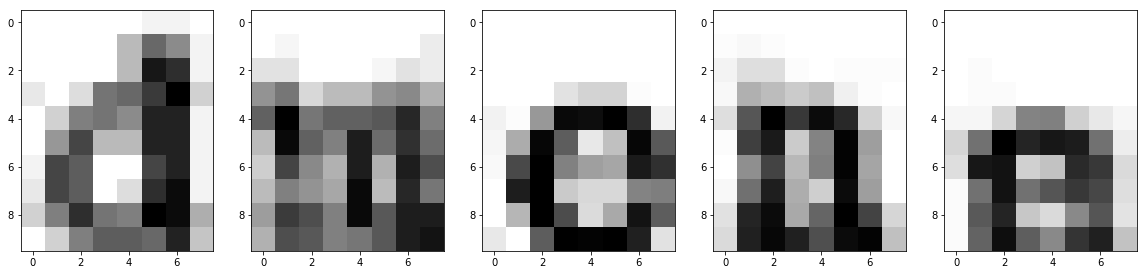

In [21]:
P = df[['label'] + columns].groupby('label').aggregate(lambda x: (sum(x) + 1.0)/(len(x) + 2.0))


fig=plt.figure(figsize=(20,5))
for i in range(5):
    fig.add_subplot(1, 5, i + 1)
    plt.imshow(P.loc[i].values.reshape([10, 8]), cmap='gray')

In [27]:
def log_likelihood(X, P):
    LogP = np.log(P)
    LogQ =np.log(1-P)
    
    LL = np.full([len(X), len(LogP)], np.nan)
    for i in range(len(LogP)):
        LL[:, i] = np.sum(LogP.loc[i].values[np.newaxis, :] * X + LogQ.loc[i].values[np.newaxis, :] * (1 - X), axis=1)
    return DataFrame(LL)

In [28]:
print(log_likelihood(df.iloc[:, 3:], P).loc[1,0])
print(np.log(P).loc[0, df.iloc[1,3:] == 1].sum() +  np.log(1-P).loc[0, df.iloc[1,3:] == 0].sum())

-50.86892407553444
-50.86892407553443


In [29]:
head(log_likelihood(df.iloc[:, 3:], P))

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,-85.338602,-73.834204,-91.269186,-65.893086,-78.493613,-61.840500,-70.551832,-60.392544,-70.384352,-60.151696,...,-78.170925,-76.782103,-72.645421,-52.197550,-75.249112,-45.504882,-32.605758,-71.750504,-62.442680,-87.998857
1,-50.868924,-43.141880,-58.584722,-51.988985,-40.777052,-37.569187,-58.713315,-54.307457,-12.891352,-40.568813,...,-51.733887,-41.605931,-34.495726,-47.934370,-51.808788,-38.905390,-51.623422,-47.644275,-62.314847,-61.563156
2,-82.632615,-63.495342,-113.480817,-94.029560,-100.587509,-73.366031,-101.941052,-25.330572,-65.484635,-53.604141,...,-90.887484,-50.581773,-54.032693,-55.718384,-89.595522,-42.898256,-64.600241,-60.283855,-84.226262,-113.941735
3,-52.532958,-47.703043,-61.919470,-23.187627,-35.761335,-47.532478,-50.007710,-61.846918,-66.974976,-66.626784,...,-53.154729,-76.496863,-70.010487,-60.088507,-42.751226,-67.688997,-52.395491,-47.810905,-39.284708,-43.486469
4,-37.032065,-39.787635,-21.466957,-29.991606,-22.389071,-50.268355,-40.989219,-62.704038,-51.526056,-58.018441,...,-38.527670,-67.054864,-66.186665,-59.309920,-24.895671,-67.575659,-61.021322,-39.451656,-56.203506,-16.927526


## V. E-step formulae for clustering and HMM

For the clustering, we must assign a weight for each character image by rescaling the likelihood matrix. More precisely, let $(p_{ij})$ be the probability that the $i$th image belongs to the $j$th cluster then 
\begin{align*}
 w_{ij} = \frac{p_{ij}}{\sum_{j} p_{ij}}\,.
\end{align*}
For the HMM we need to compute two marginal probabilities:
* $\gamma_{j}(i)$ – probability that the $i$th internal state is $j$ given the observation vector and HMM parameters.
* $\xi_{jk}(i)$ – probability that the $i$th and $(i+1)$th internal states are $j$ and $k$ given the observation  vector and HMM parameters.

More formally,

\begin{align*}
\gamma_{j}(i)&=\Pr[x_i=j|\boldsymbol{y},\boldsymbol{\Theta}]\,,\\
\xi_{jk}(i)&=\Pr[x_i=j, x_{i+1}=k|\boldsymbol{y},\boldsymbol{\Theta}]\,.
\end{align*}

In [30]:
LL = log_likelihood(df.iloc[:, 3:], P)

In [43]:
Lambda = df['label'].value_counts(normalize=True).sort_index()
Lambda

0     0.019349
1     0.026385
2     0.067722
3     0.060686
4     0.050132
5     0.029903
6     0.041337
7     0.009675
8     0.019349
9     0.029903
10    0.021988
11    0.018470
12    0.027265
13    0.020229
14    0.042216
15    0.045734
16    0.019349
17    0.040457
18    0.023747
19    0.020229
20    0.036060
21    0.019349
22    0.019349
23    0.008795
24    0.056288
25    0.023747
26    0.044855
27    0.020229
28    0.012313
29    0.025506
30    0.027265
31    0.013193
32    0.013193
33    0.008795
34    0.036939
Name: label, dtype: float64

In [48]:
LL = LL-LL.apply(max, axis=1).values[:, np.newaxis]
W = np.exp(LL) * Lambda.values[np.newaxis, :]
W = W/ W.sum(axis=1)[:, np.newaxis]
display(head(W))

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,1.839271e-23,2.486800e-18,1.710386e-25,1.607506e-14,4.475474e-20,4.558252e-13,1.037847e-16,6.274095e-13,5.743732e-17,2.467382e-12,...,2.927316e-20,2.217348e-19,6.259353e-18,2.892858e-09,5.840241e-19,5.165942e-06,9.997639e-01,9.989648e-18,7.341683e-14,2.455491e-24
1,3.210333e-17,9.932562e-14,5.008294e-20,3.285036e-17,2.008384e-12,2.962162e-11,2.688127e-20,5.154471e-19,1.000000e+00,1.475325e-12,...,1.658985e-17,7.844482e-13,4.331565e-10,3.843403e-16,1.653285e-17,7.098819e-12,1.029306e-17,5.503841e-16,1.560366e-22,1.389731e-21
2,2.600572e-25,7.260718e-17,3.646975e-38,9.159349e-30,1.073518e-32,4.251590e-21,2.286631e-33,9.999999e-01,7.283530e-18,1.625665e-12,...,8.297857e-29,5.008645e-11,7.164109e-13,8.081203e-14,3.244083e-28,6.613338e-08,1.202535e-17,9.009082e-16,2.401784e-26,1.254635e-38
3,5.741871e-14,9.802972e-12,1.685044e-17,9.999895e-01,2.859757e-06,1.317621e-11,1.532604e-12,2.588344e-18,3.068774e-20,6.717984e-20,...,3.784105e-14,5.209658e-24,1.541574e-21,1.911726e-17,1.340236e-09,2.117427e-20,4.491829e-14,4.400314e-12,1.480038e-08,9.305089e-10
4,9.482148e-10,8.220090e-11,1.909041e-02,3.395983e-06,5.619926e-03,2.615262e-15,3.872682e-11,3.362641e-21,4.811123e-16,1.126407e-18,...,2.608044e-10,2.010566e-22,2.160379e-22,1.274860e-19,2.331585e-04,7.259914e-23,2.467024e-20,5.751226e-11,2.034384e-18,9.750424e-01


## VI. M-step formulae for clustering and HMM

For the clustering, we can use the maximum likelihood formula with Laplace smoothing to update the matrix of bias vectors (defined in the code above):

\begin{align*}
P_{j\ell} = \frac{\sum_i w_{ij}[Y_{i\ell}=1]+1}{\sum_{i}w_{ij}+2}\,,
\end{align*}

where $Y$ is the matrix of texture vectors.

The HMM emission probabilities can also be calculated using the maximum likelihood formula with Laplace smoothing:

\begin{align*}
\delta_{j\ell} = \frac{\sum_i \gamma_j(i)[y_{i}=\ell]+1}{\sum_{i}\gamma_{j}(i)+2}\,,
\end{align*}

where $y$ is the vector of observation labels.

The HMM transition probabilities for a single observation sequence can be calculated using the following formulae:

\begin{align*}
\beta_j&=\gamma_{j}(1)\,,\\
\alpha_{jk}&=\frac{\sum_{i} \xi_{jk}(i)}{\sum_i \gamma_j(i)}\,.
\end{align*}

The generalisation to multiple observation sequences (words) as in our problem is obvious – we just compute sums over all observations and normalise appropriately.

# Homework

## 1.1 Implement soft clustering for Bernoulli mixtures (<font color='red'>2p</font>)

The formulae given above are enough to implement the EM-algorithm for Bernoulli mixtures. Write a simple implementation that does 100 iterations before stopping. Test this on the contexts prepared above. Initialise the algorithm with the labellings obtained with the hierarchical clustering and random parameters. Test which of them performs better. You can do it by comparing some of the clusters visually or by computing the marginal posterior. 

## 1.2 Implement E-step for the HMM with Bernoulli emissions (<font color='red'>2p</font>)

Implement weight computation for the HMM. The computation of $\gamma_{j}(i)$ has already been done in the HMM exercise session, as this is a marginal state probability given all observations. For the weights $\xi_{jk}(i)$, you need to define a computation scheme that is analogous. Check the consistency of your derivations through the following formula:

\begin{align*}
  \gamma_{j}(i)=\sum_k\xi_{jk}(i)\,.
\end{align*}

As you have many observation sequences (words), you need to be careful about indices. 

## 1.3 Impement EM-algorithm for the HMM with Bernoulli emissions (<font color='red'>2p</font>)

First, implement the M-step by updating the parameters and then assemble the entire algorithm. Again use 100 iterations as a stopping criterion. Run the algorithm on the dataset and output the cluster shapes.
Label them manually and draw the corresponding starting probabilities and transition matrices similarly to how we did in the HMM exercise session. Can this algorithm be used in practice?

## 1.4 Location improvements for soft clustering* (<font color='red'>3p</font>)

The alignment of characters was very crude. Thus it makes sense to assign an observation to a cluster together with a shift $\Delta$ that corrects for the misplacement of the letter box. Formally, you have 35 clusters and each of them has subclusters defined by $\Delta$. All these subclusters share the same probability matrix that is slightly larger than $10\times 8$ to assign probabilities for all observations. To make computations tractable, you need to choose one shift for each cluster assignment – then each datapoint still has 35 clusters and the weight matrix does not explode. 

## 1.5 Location improvements for the HMM* (<font color='red'>3p</font>)

The alignment of characters was very crude. Thus it makes sense to assign an observation to a cluster together with a shift $\Delta$ that corrects for the misplacement of the letter box. Again assign one shift for each cluster-observation pair. After that, the update of the HMM parameters is the same as for the normal HMM.  

## 1.6 Location improvements for the HMM by changing the emission distribution* (<font color='red'>5p</font>)

Another way to model shifts is to incorporate them into the generation model. That is, the probability of an image is computed as a marginal distribution 

\begin{align*}
\Pr[image] =\sum_{\Delta} Pr[\Delta]\cdot \Pr[image|p_{xy}, \Delta]
\end{align*}

where $p_{xy}$ are the bias terms for the pixels and $\Delta$ shifts this matrix accordingly. You can assign a spherical normal distribution with a small enough width for this. To avoid integration, you can just sample many shifts and compute the average as an approximation. 

The problematic step is the parameter estimation itself as we need to maximise the marginal posterior. This can be solved with an EM algorithm. Hence, the implementation will have EM inside EM. This makes things very complicated.